In [1]:
from pulsar_analysis import pulsar_analysis
from generic_plotting import *
#%autoreload 1

In [2]:
# Initialize and run the analysis
long_data = "./Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt"
short_data = "/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Analysis/vela_chunks/chunk_0001.txt"

vela = pulsar_analysis(long_data, channel_names=["N", "S"], data_type='ascii')
vela.compute_intensity_matrix()


Given Data is of ndim : 2 . shape : 2
file_path: ./Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt
data_type: ascii
n_channels: 2
raw_data shape :  (30720000, 2)
channel_names: ['N', 'S']
block_size: 512
avg_blocks: 60
sample_rate: 33000000.0
intensity_matrix_ch_s shape :  (2,)
dedispersed_ch_s shape :  (2,)
dedispersed_choped_ch_s: [None None]
folded_ch_s: [None None]
center_freq_MHZ: 326.5
bandwidth_MHZ: 16.5


In [3]:
percentofData = 40 # Percentage of data to analyze
n = int(vela.raw_data.shape[0] * percentofData / 100)

ch0 = vela.raw_data[:n , 0]
ch1 = vela.raw_data[:n, 1]
fs = vela.sample_rate

# compare_channels(ch0,ch1, fs, label="Comparision of N and S channels",)

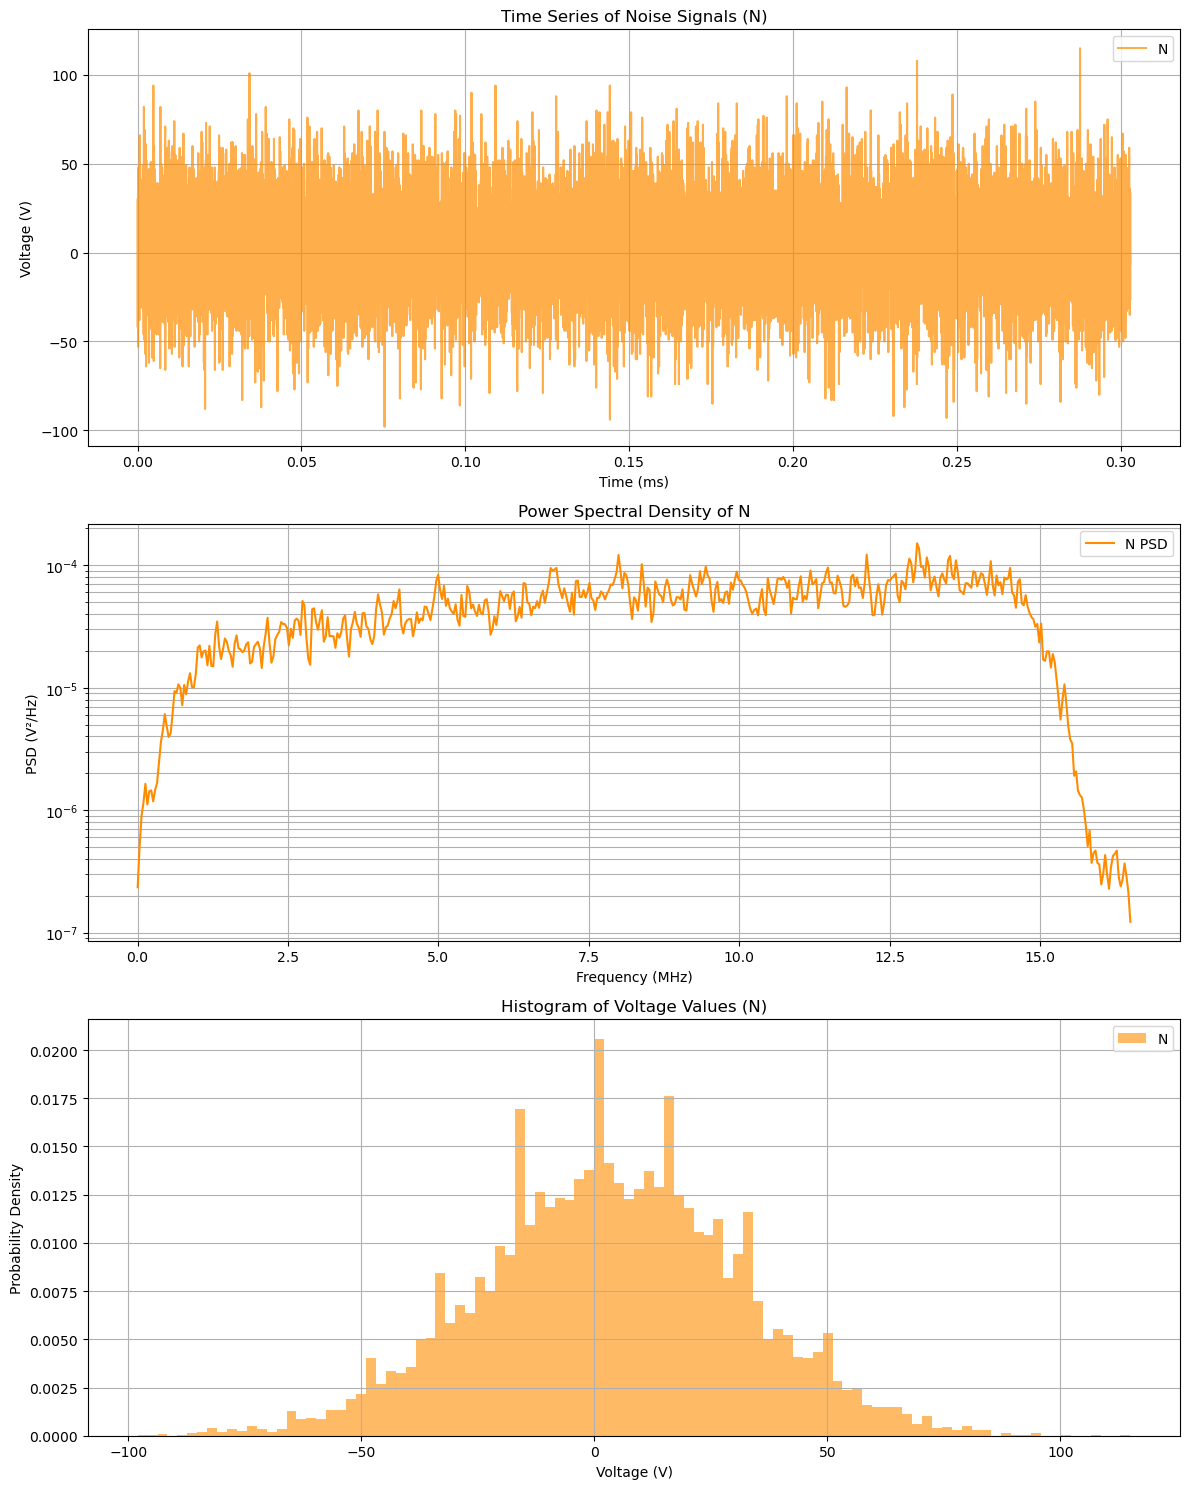

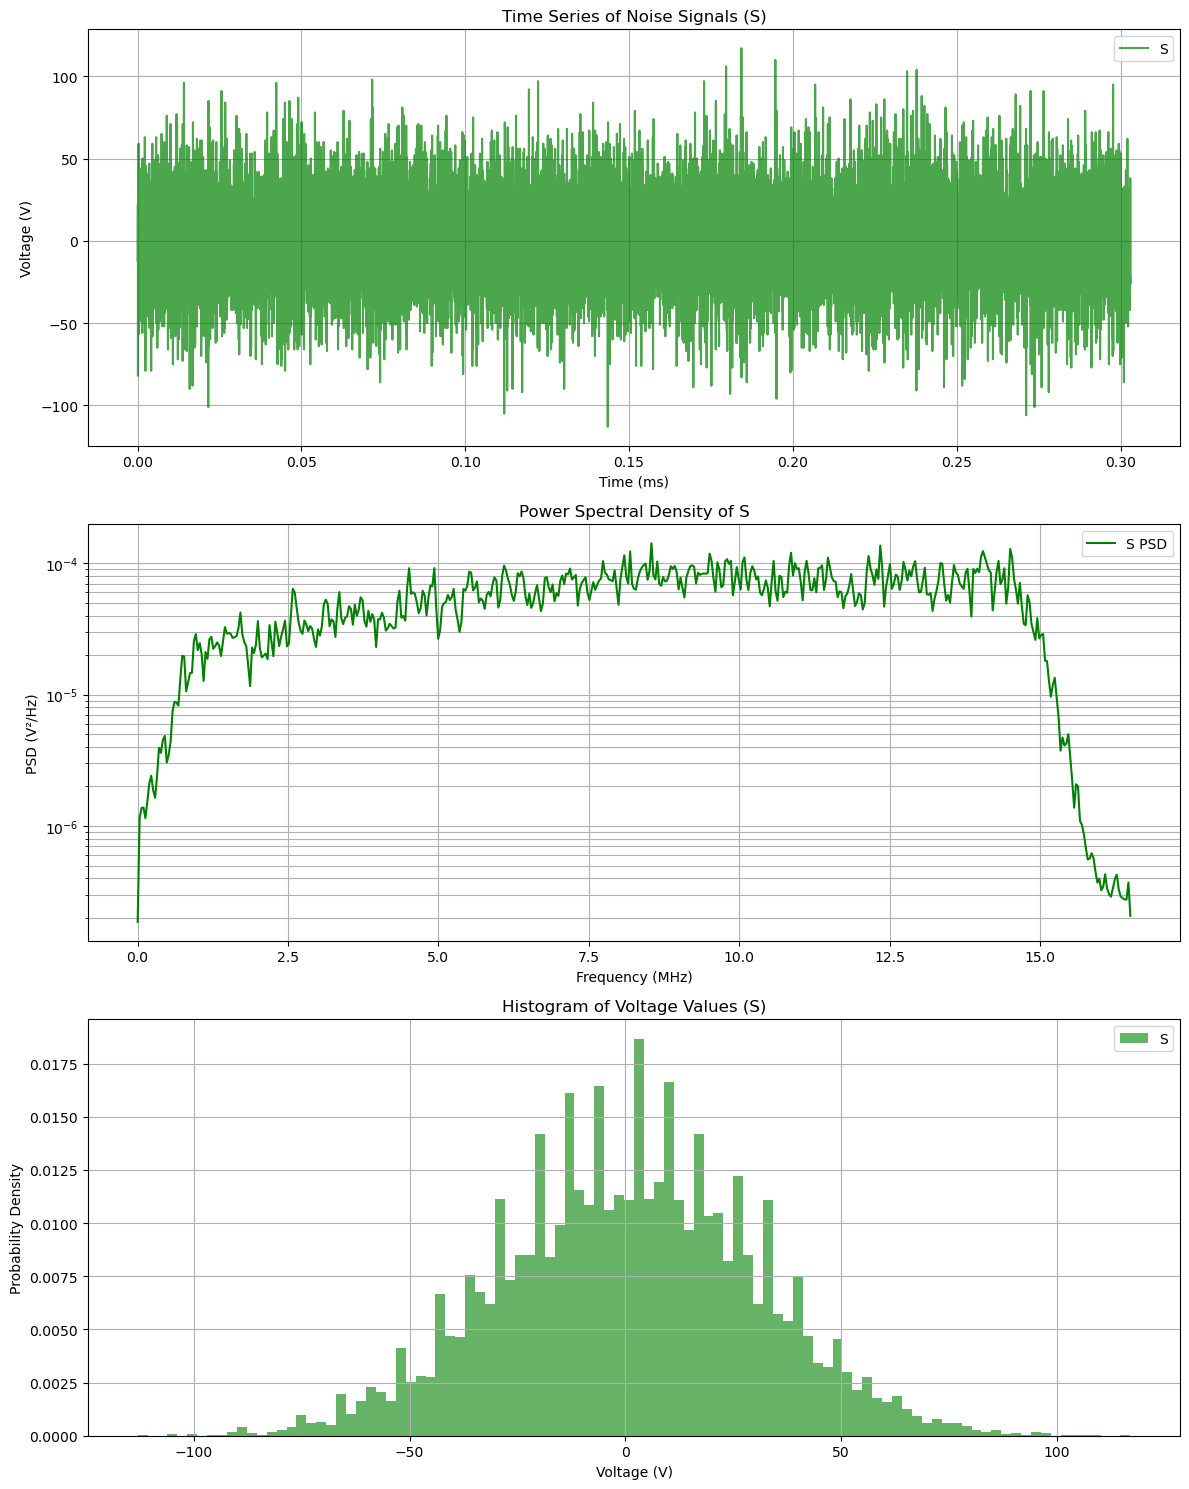

In [4]:
Plot_characterstics(vela,channel=0)
Plot_characterstics(vela,channel=1)

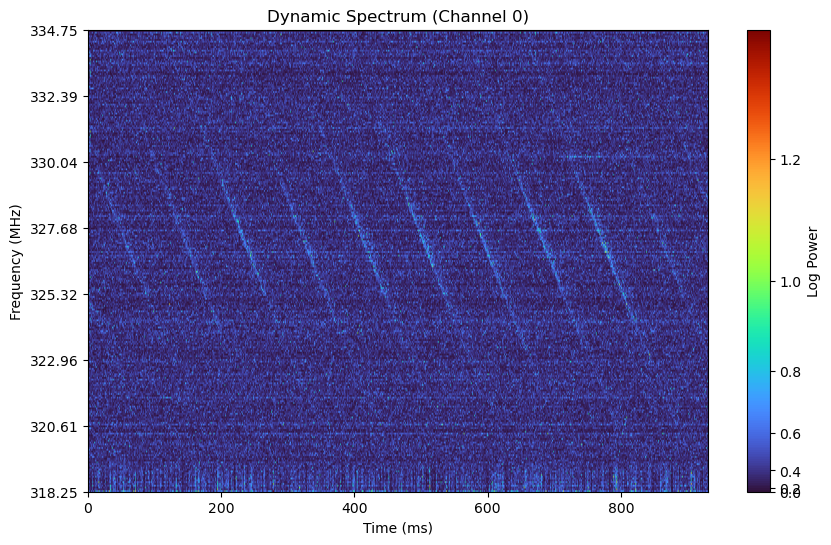

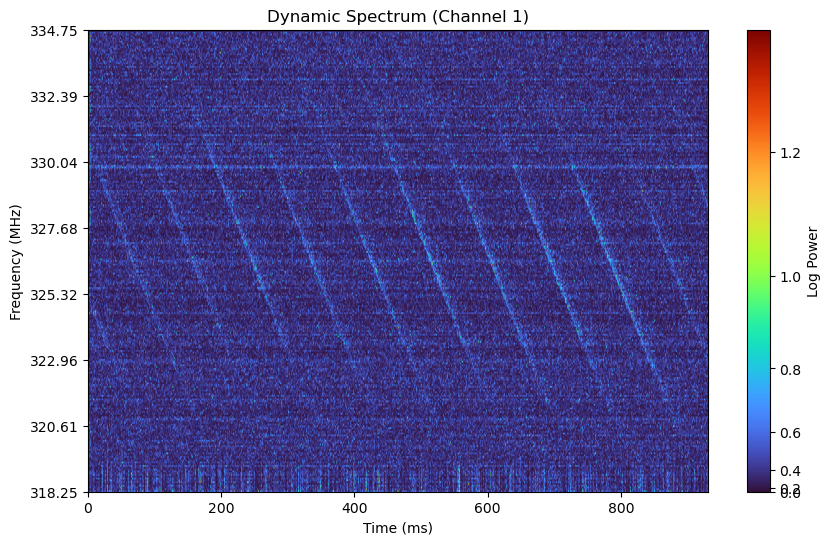

In [5]:
plot_intensity_matrix(vela,channel = 0)

plot_intensity_matrix(vela,channel = 1)


Top 3 peak positions (ms): [ 88.43636364  90.29818182 177.80363636]


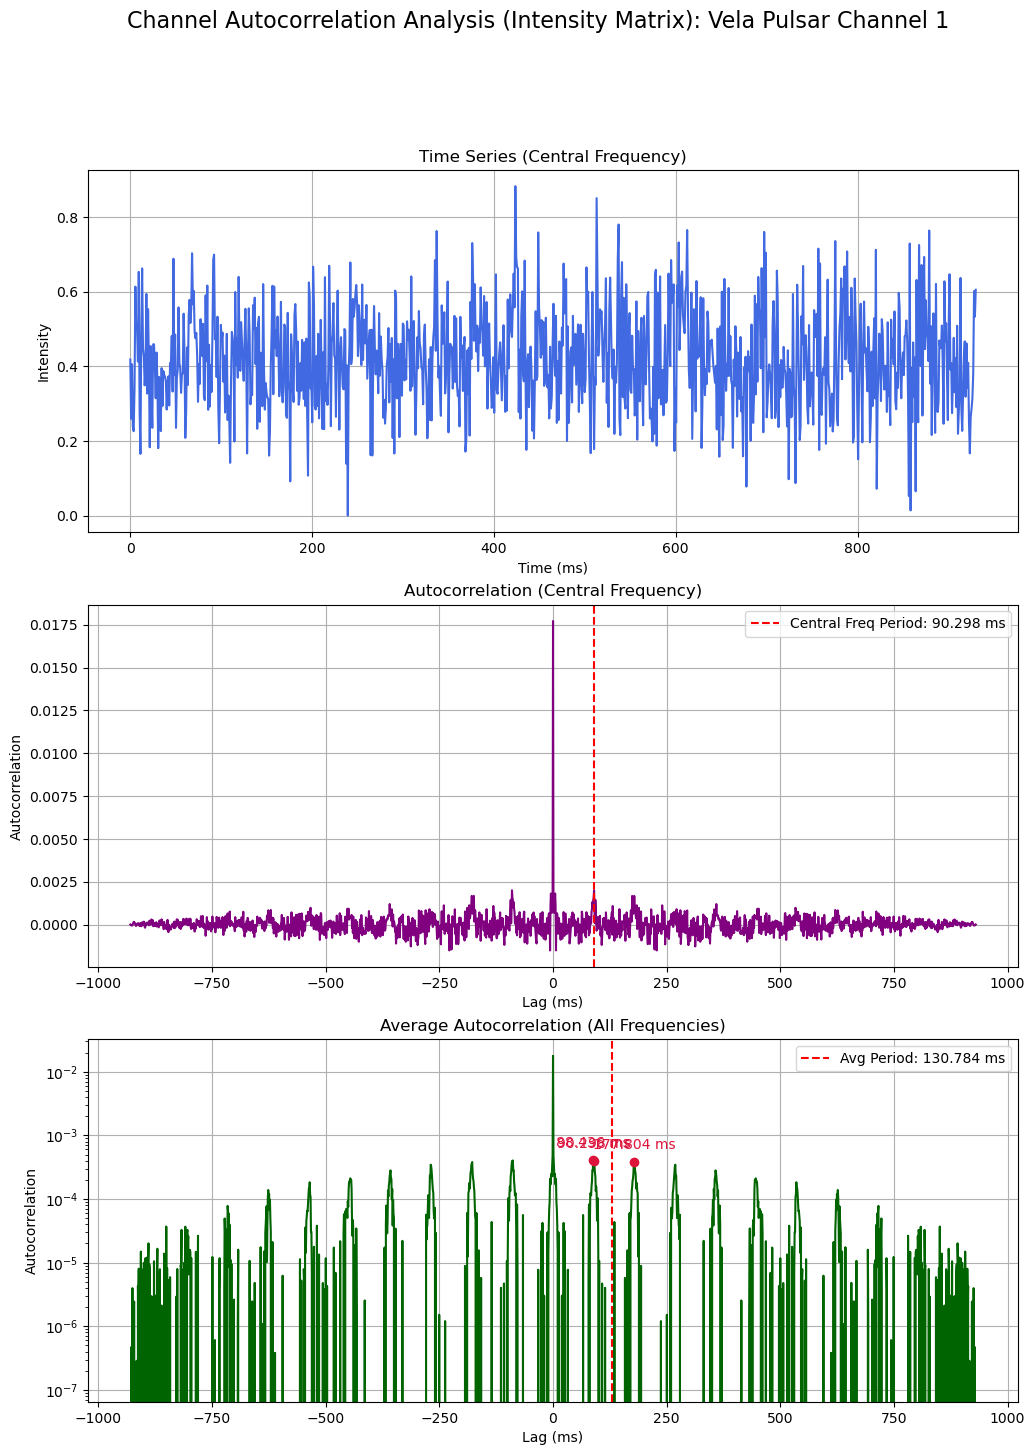

Top 3 peak positions (ms): [ 89.36727273 178.73454545 269.03272727]


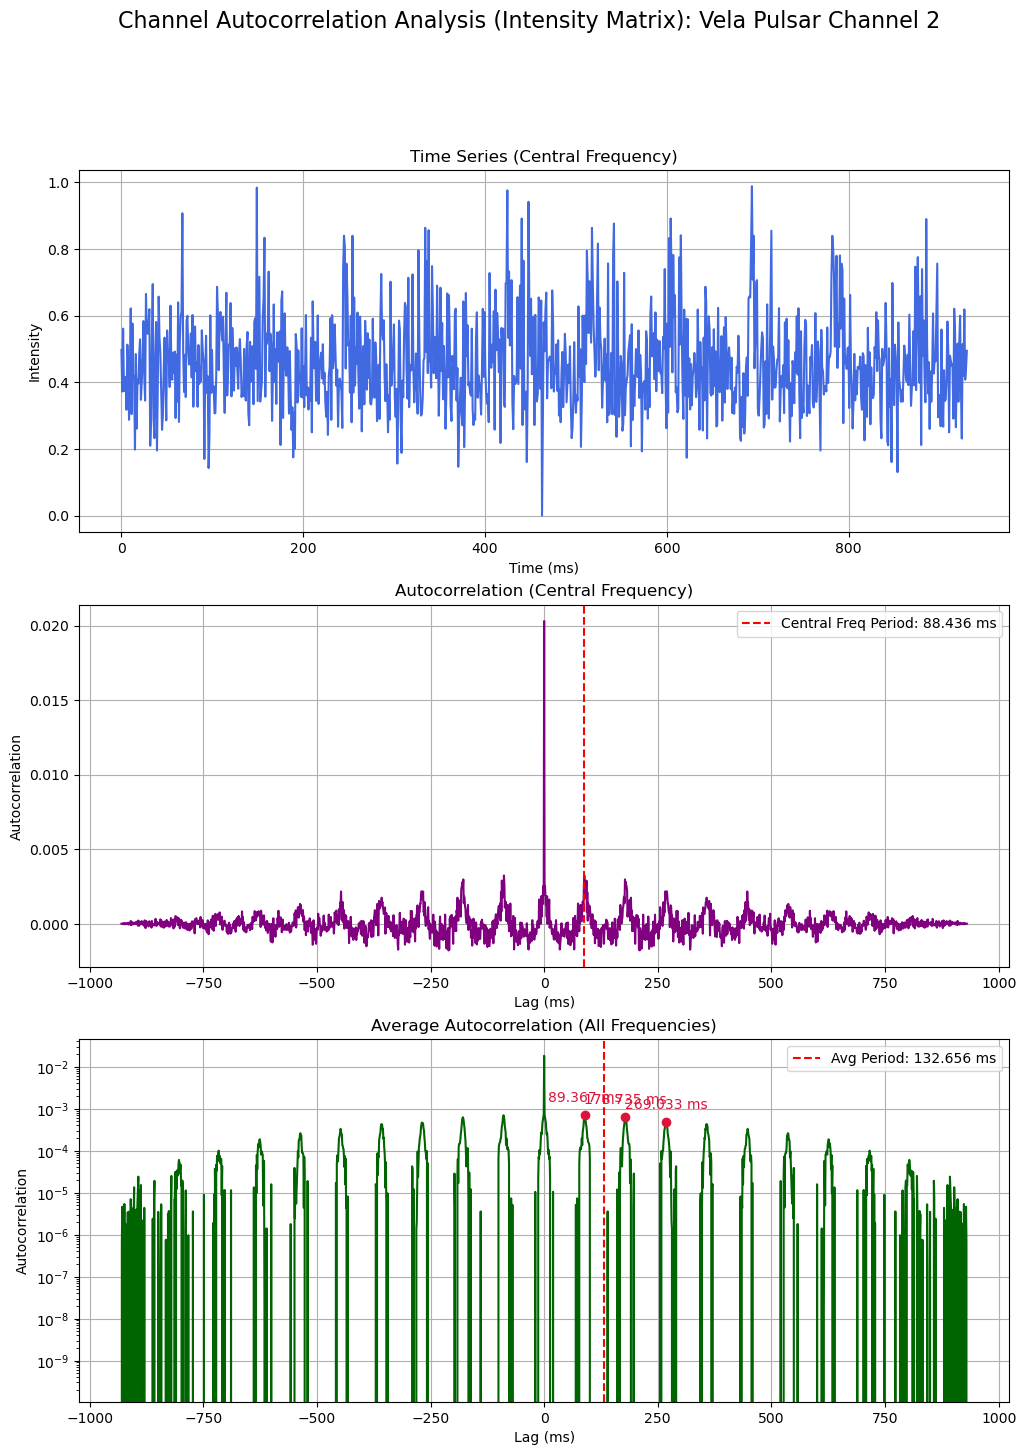

In [6]:
analyze_autocorrelation(vela,channel=0, label="Vela Pulsar Channel 1")
analyze_autocorrelation(vela,channel=1, label="Vela Pulsar Channel 2")


In [7]:
# Set pulsar Period
vela.pulseperiod_ms = 89.3673

Gaussian fit maximum at DM = 68.93259, Score = 3.05772


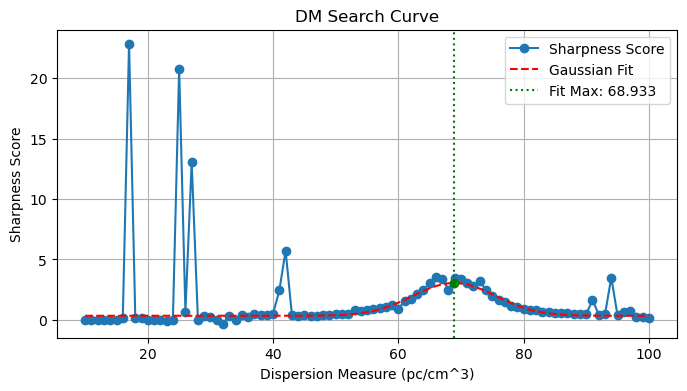

Gaussian fit maximum at DM = 69.55875, Score = 4.23011


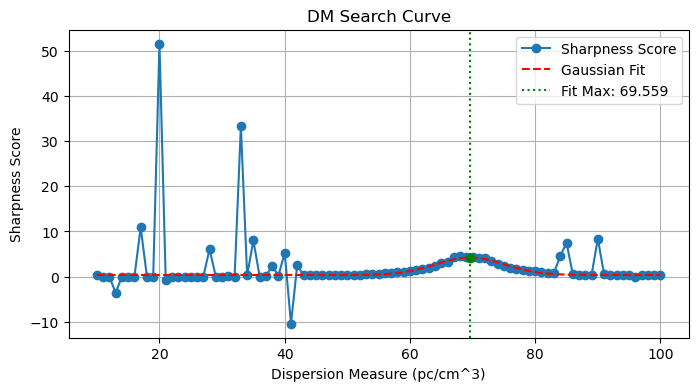

In [8]:
channel = 0
num_peaks = 10
to_plot = False
dm_min = 10.0
dm_max = 100.0
tol = 1

score = vela.Auto_dedisperse(channel,num_peaks,to_plot,dm_min, dm_max,tol = tol)
plot_dm_curve(np.array(score)[:,0], np.array(score)[:,1])

channel = 1
score = vela.Auto_dedisperse(channel,num_peaks,to_plot,dm_min, dm_max,tol = tol)
plot_dm_curve(np.array(score)[:,0], np.array(score)[:,1])


Gaussian fit maximum at DM = 68.45007, Score = 3.37365


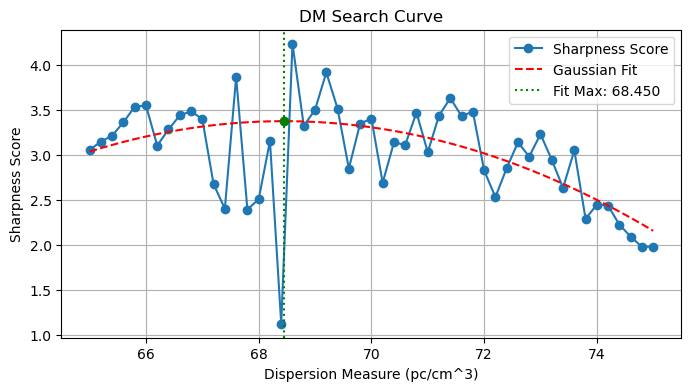

Gaussian fit maximum at DM = 69.30513, Score = 4.68361


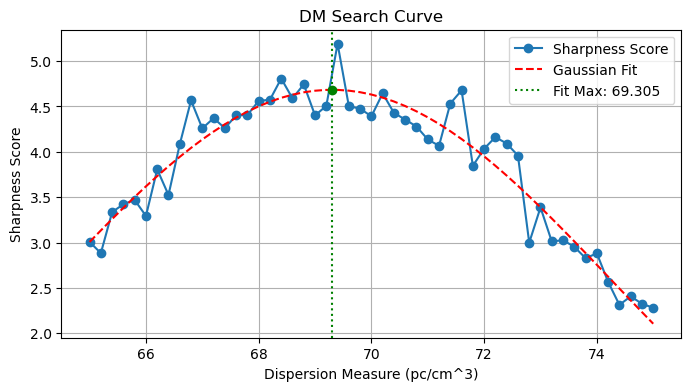

In [9]:
channel = 0
num_peaks = 10
to_plot = False
dm_min = 65.0
dm_max = 75.0
tol = 0.2

score = vela.Auto_dedisperse(channel,num_peaks,to_plot,dm_min, dm_max,tol = tol)
plot_dm_curve(np.array(score)[:,0], np.array(score)[:,1])

channel = 1
score = vela.Auto_dedisperse(channel,num_peaks,to_plot,dm_min, dm_max,tol = tol)
plot_dm_curve(np.array(score)[:,0], np.array(score)[:,1])


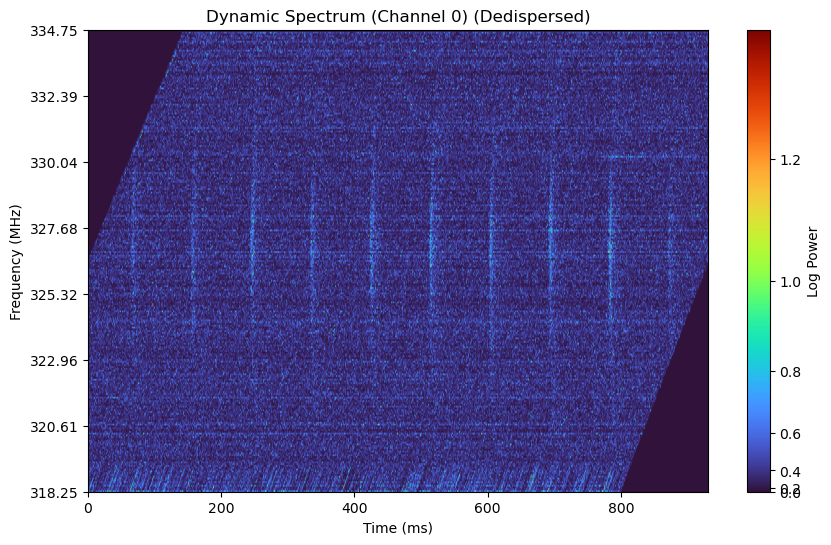

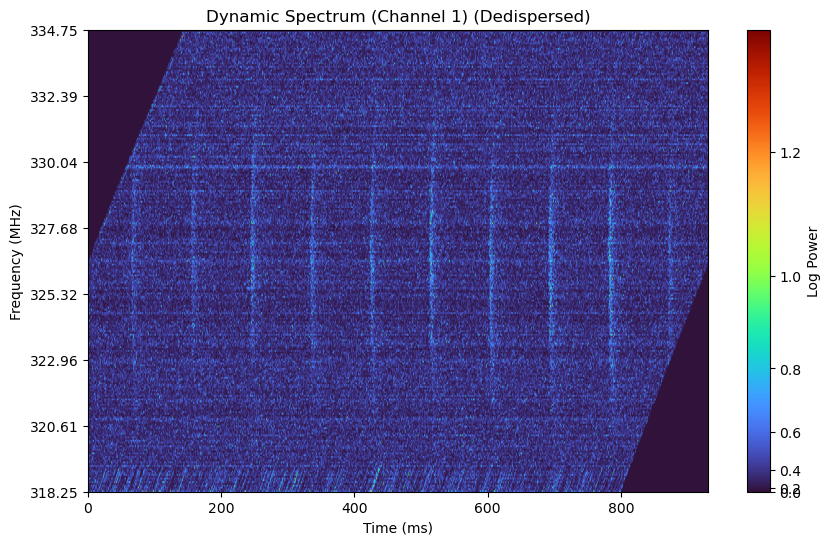

In [10]:
# give integer for a single channel or String "all" for all channels
vela.dedispersion_measure = 69.750

best_DM = vela.dedispersion_measure
channel = 0

vela.Manual_dedisperse(DM=best_DM, channel="all")
plot_intensity_matrix(vela,channel ,dedispersed=True)

channel = 1
plot_intensity_matrix(vela,channel,dedispersed=True)

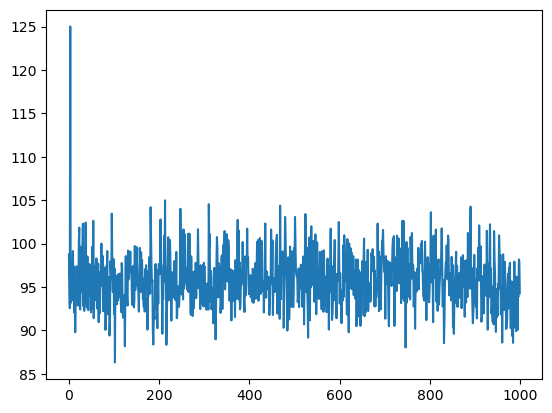

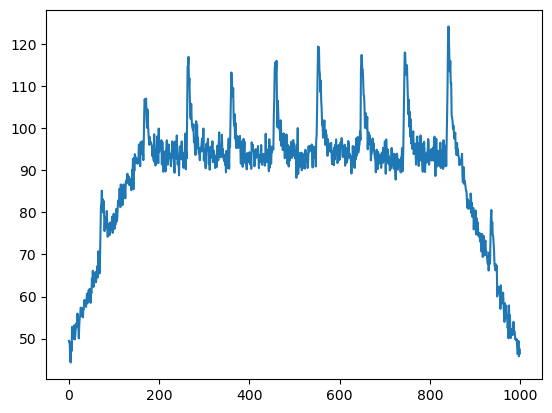

In [11]:
# folding

channel = 1
profile = vela.intensity_matrix_ch_s[channel].sum(axis=1)
plt.plot(profile, label="channel 1")
plt.show()

profile = vela.dedispersed_ch_s[channel].sum(axis=1)
plt.plot(profile, label="channel 1" )
plt.show()



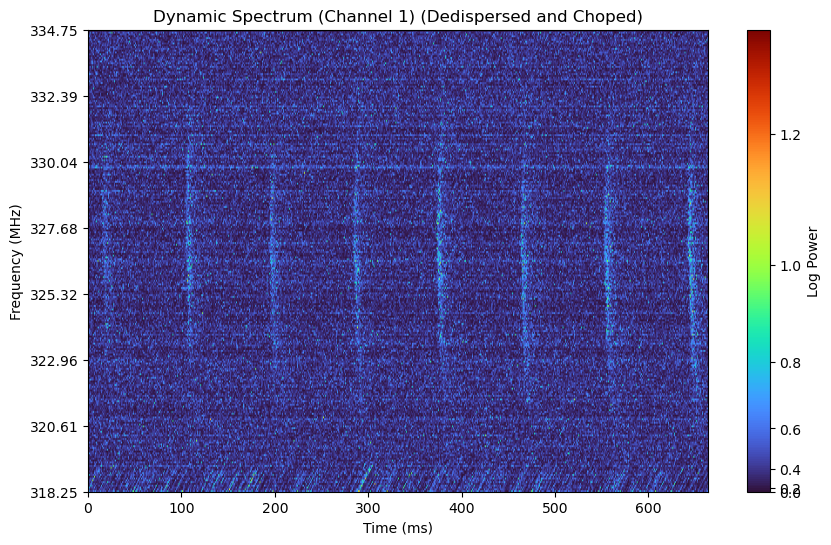

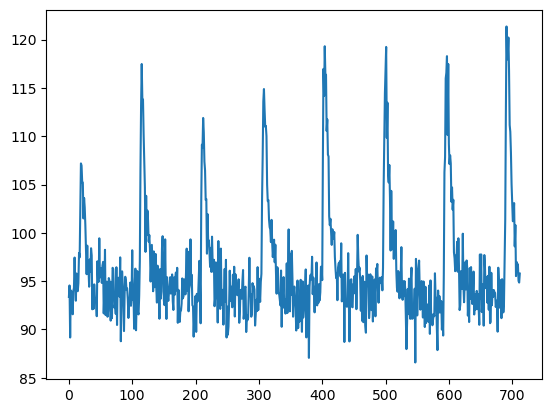

In [12]:

# matrix = vela.intensity_matrix_ch_s[1]
block_size = vela.block_size
avg_blocks = vela.avg_blocks
sample_rate = vela.sample_rate
DM = 68 # Vela DM

channel= "all"
vela.Manual_dedisperse_pop(DM, channel)

plot_intensity_matrix(vela, channel=1, dedispersed=True, choped=True)

channel = 1
profile = vela.dedispersed_choped_ch_s[channel].sum(axis=1)
plt.plot(profile, label="channel 1" )
plt.show()



In [13]:
vela.pulseperiod_ms = 90
matrix  = vela.dedispersed_choped_ch_s[1]
sample_rate = vela.sample_rate
pulse_period_s = vela.pulseperiod_ms / 1000.0
bandwidth_MHZ = vela.bandwidth_MHZ
center_freq_MHZ = vela.center_freq_MHZ



In [14]:
def Anti_line_Noise(mat):
    mat = mat[:,:] / np.mean(mat,axis=0)
    return mat - np.min(mat, axis=0)

def anti_line_noise_median(mat):
    norm = np.median(mat, axis=0)
    mat = mat / norm
    mat = mat - np.min(mat, axis=0)
    return mat

def Anti_line_Normalise(mat):
    mat = mat[:,:] / np.mean(mat,axis=0)
    return mat

def fold_time_series_from_matrix(matrix, pulse_period_s, t_bin):

    elements_to_shift = int(pulse_period_s / t_bin)

    n_samples = matrix.shape[0]
    n_segments = n_samples // elements_to_shift

    folded_profile = np.zeros((elements_to_shift, matrix.shape[1]))
    for i in range(n_segments):
        start = i * elements_to_shift
        end = start + elements_to_shift
        folded_profile += matrix[start:end, :]
        # plot_intensity_matrix_single(folded_profile, block_size,avg_blocks,sample_rate,bandwidth_MHZ,center_freq_MHZ,gamma=2.5)
    folded_profile /= n_segments

    return folded_profile



def plot_intensity_matrix_single(matrix, block_size,avg_blocks,sample_rate,bandwidth_MHZ,center_freq_MHZ,gamma=2.5):

    num_segments, n_freq = matrix.shape
    time_bin_us = (block_size * avg_blocks / sample_rate) * 1e6
    time_extent_ms = num_segments * time_bin_us / 1000

    # Frequency axis
    bandwidth = bandwidth_MHZ #16.5  # MHz
    center_freq = center_freq_MHZ # 326.5  # MHz
    freq_array = np.linspace(center_freq + bandwidth / 2, center_freq - bandwidth / 2, n_freq)

    plt.figure(figsize=(10, 6))
    plt.imshow(matrix.T, aspect='auto', origin='upper', cmap='turbo',
                norm=colors.PowerNorm(gamma=gamma),
                extent=(0, time_extent_ms, freq_array[-1], freq_array[0]))
    plt.colorbar(label="Power")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")
    yticks = np.linspace(freq_array[0], freq_array[-1], 8)
    plt.yticks(yticks)
    plt.show()

In [15]:
matrix = vela.dedispersed_choped_ch_s[1]
t_bin_s = (vela.block_size * vela.avg_blocks) / vela.sample_rate

folded = fold_time_series_from_matrix(matrix, pulse_period_s, t_bin_s)

folded1 = fold_time_series_from_matrix(folded, pulse_period_s, t_bin_s)


In [16]:
print( np.mean(folded) , np.std(folded) )
print( np.mean(folded1) , np.std(folded1) )

print(np.mean(Anti_line_Noise(folded)), np.std(Anti_line_Noise(folded)))
print(np.mean(anti_line_noise_median(folded)), np.std(anti_line_noise_median(folded)))

0.3736359222109034 0.06673719258923064
0.3736359222109034 0.06673719258923064
0.33374316563244677 0.16508952658772655
0.33721859541522203 0.1672137548705594


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def detect_rising_edges(matrix, sigma=1.5, height_threshold=0.5, distance=10, to_plot=True):
    """
    Detect rising edges from a dynamic spectrum (2D matrix).
    Returns time indices of rising edges.
    """
    
    # Step 1: Collapse across frequency (sum over axis=1 → time axis)
    time_profile = np.sum(matrix, axis=1)

    # Step 2: Smooth to reduce noise
    smoothed = gaussian_filter1d(time_profile, sigma=sigma)

    # Step 3: Compute derivative (rising edge → large positive slope)
    derivative = np.diff(smoothed)
    derivative = derivative/np.max(derivative)  # Normalize derivative for better peak detection
    # Step 4: Detect peaks in derivative (i.e., sharp rises)
    peaks, _ = find_peaks(derivative, height=height_threshold, distance=distance)

    if to_plot:
        plt.figure(figsize=(10, 5))
        plt.plot(smoothed[:-1], label="Smoothed Profile")
        plt.plot(peaks, smoothed[peaks], 'ro', label="Rising Edges")
        plt.title("Detected Rising Edges in Time Profile")
        plt.xlabel("Time Bin")
        plt.ylabel("Summed Intensity")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        plt.plot(derivative, label="Derivative of Smoothed Profile")
        plt.plot(peaks, derivative[peaks], 'ro', label="Rising Edges")
        plt.title("Rising Edges in Derivative")
        plt.xlabel("Time Bin")
        plt.ylabel("Derivative")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()  
    return peaks

def fold_time_series_by_edges(matrix, rising_edge_indices):
    """
    Fold a dynamic spectrum matrix using segments between rising edges.
    Each segment (between consecutive rising edges) is assumed to be one pulse.
    """
    if len(rising_edge_indices) < 2:
        raise ValueError("Need at least two rising edges to fold.")

    segment_length = np.min(np.diff(rising_edge_indices))  # Use shortest segment to avoid mismatches
    n_freq = matrix.shape[1]
    folded_profile = np.zeros((segment_length, n_freq))
    count = 0

    for i in range(len(rising_edge_indices) - 1):
        start = rising_edge_indices[i]
        end = rising_edge_indices[i + 1]
        segment = matrix[start:end, :]

        if segment.shape[0] >= segment_length:
            folded_profile += segment[:segment_length, :]
            count += 1

    if count > 0:
        folded_profile /= count
    else:
        raise ValueError("No valid segments found for folding.")

    return folded_profile


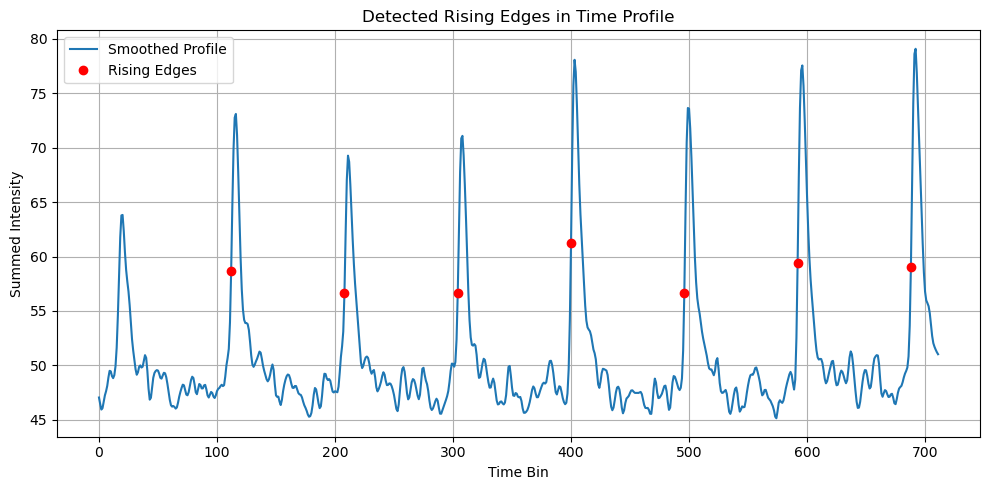

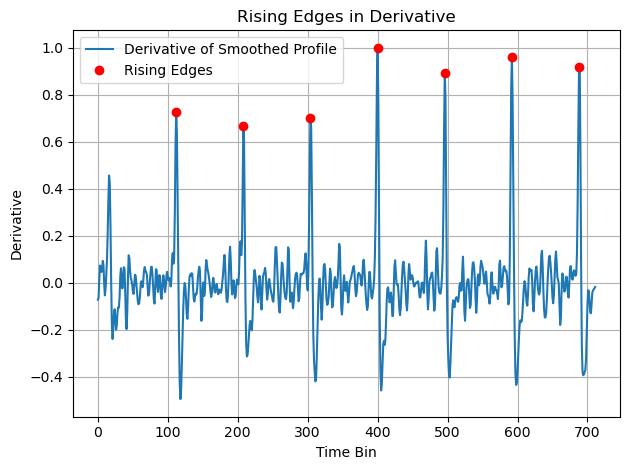

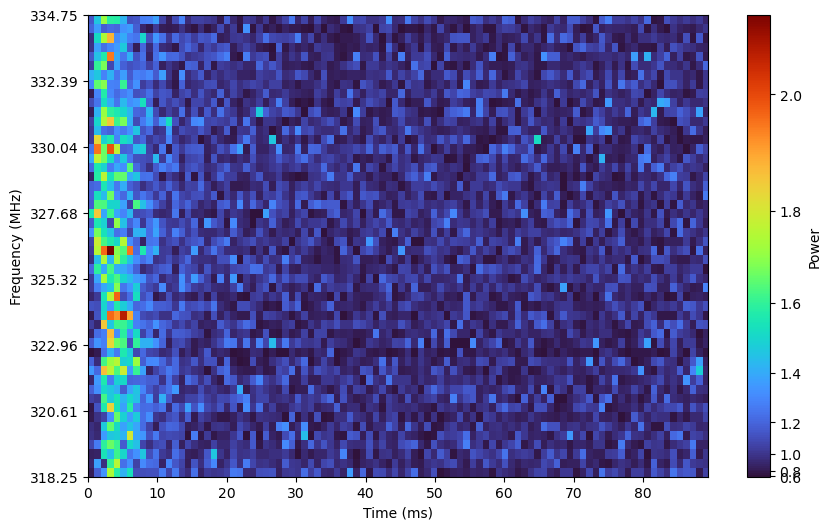

In [26]:
matrix = vela.dedispersed_choped_ch_s[1]
matrix = anti_line_noise_median(matrix[:,100:150])

# Step 1: detect edges
rising_edges = detect_rising_edges(matrix, sigma=1.5, height_threshold=0.6, distance=10)

# Step 2: fold by edges
folded = fold_time_series_by_edges(matrix, rising_edges)

# Now you can plot or analyze `folded`
plot_intensity_matrix_single(folded, vela.block_size, vela.avg_blocks, vela.sample_rate, vela.bandwidth_MHZ, vela.center_freq_MHZ, gamma=2.5)


0.9954941825027075 0.377026451448218
3.3934678391519006 0.0


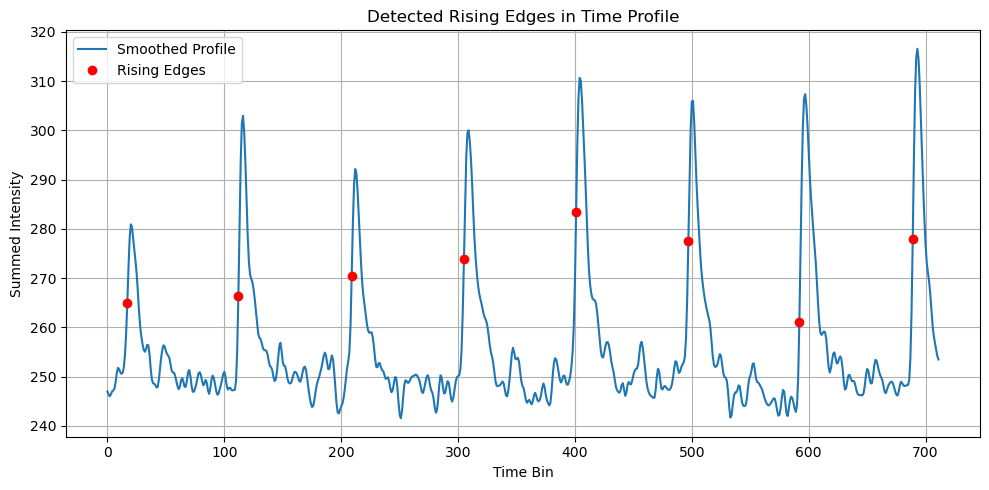

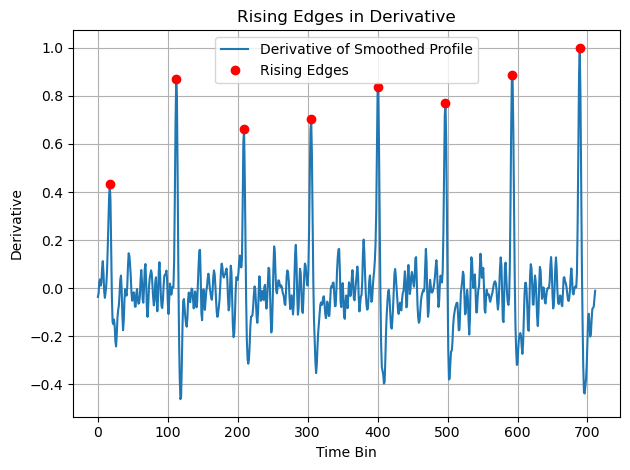

array([ 17, 112, 209, 305, 401, 497, 592, 689])

In [19]:
matrix = vela.dedispersed_choped_ch_s[1]
matrix = anti_line_noise_median(matrix)
print( np.mean(matrix) , np.std(matrix) )
print( np.max(matrix) , np.min(matrix) )



detect_rising_edges(matrix, sigma=1.5, height_threshold=0.4, distance=10, to_plot=True)

# plot_intensity_matrix_single(Anti_line_Noise(matrix), vela.block_size, vela.avg_blocks, vela.sample_rate, vela.bandwidth_MHZ, vela.center_freq_MHZ, gamma=2.5)
# plot_intensity_matrix_single(anti_line_noise_median(matrix), vela.block_size, vela.avg_blocks, vela.sample_rate, vela.bandwidth_MHZ, vela.center_freq_MHZ, gamma=2.5)

# t_bin_s = (vela.block_size * vela.avg_blocks) / vela.sample_rate

# folded = fold_time_series_from_matrix(Anti_line_Noise(matrix), pulse_period_s, t_bin_s)
# plot_intensity_matrix_single(folded, vela.block_size, vela.avg_blocks, vela.sample_rate, vela.bandwidth_MHZ, vela.center_freq_MHZ, gamma=2.5)

# folded = fold_time_series_from_matrix(anti_line_noise_median(matrix), pulse_period_s, t_bin_s)
# plot_intensity_matrix_single(folded, vela.block_size, vela.avg_blocks, vela.sample_rate, vela.bandwidth_MHZ, vela.center_freq_MHZ, gamma=2.5)




(96, 50)
[  0  28  57  85 114 142 171 199 228 257]


/tmp/ipykernel_388911/66999642.py:5: RuntimeWarning: invalid value encountered in divide
  array = array/np.max(array)


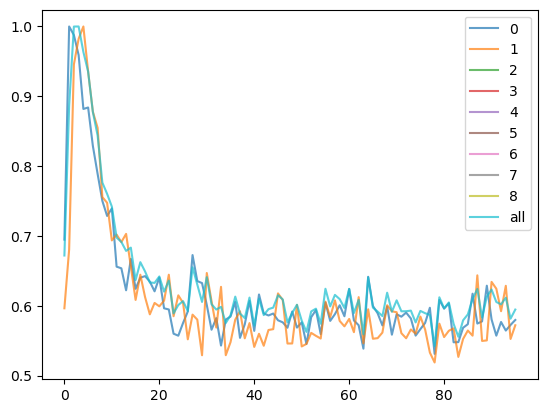

In [20]:
print(folded.shape)


def normalize(array):
    array = array/np.max(array)
    # array = array - np.min(array)*np.ones_like(array)
    return array

steps = 10
plotrange = np.linspace(0,257,steps,dtype=np.int16)

print(plotrange)
for i in range(steps-1):
    # if i in [0,7,8,9]:
    #     continue
    plt.plot(normalize(folded[:,plotrange[i]:plotrange[i+1]].sum(axis=1) ), label=f"{i}",alpha =0.7 )
    #plt.show()
plt.plot(normalize(folded.sum(axis=1) ), label=f"all",alpha =0.7 )
plt.legend()
plt.show()


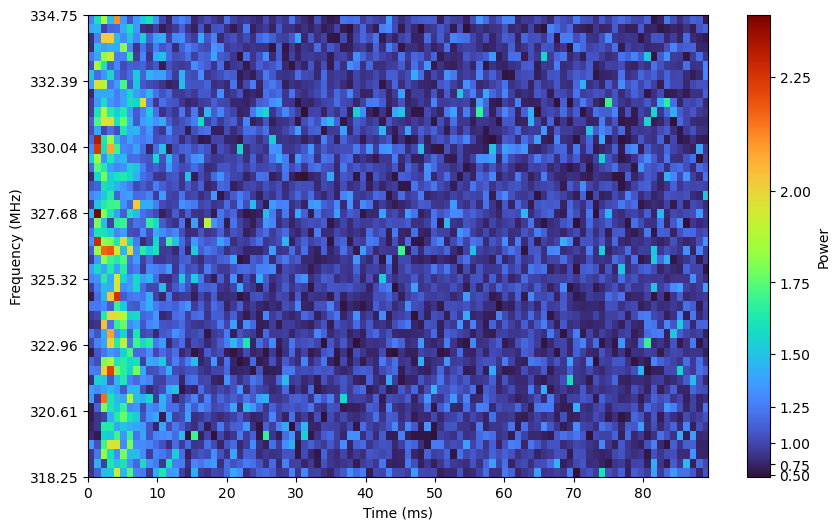

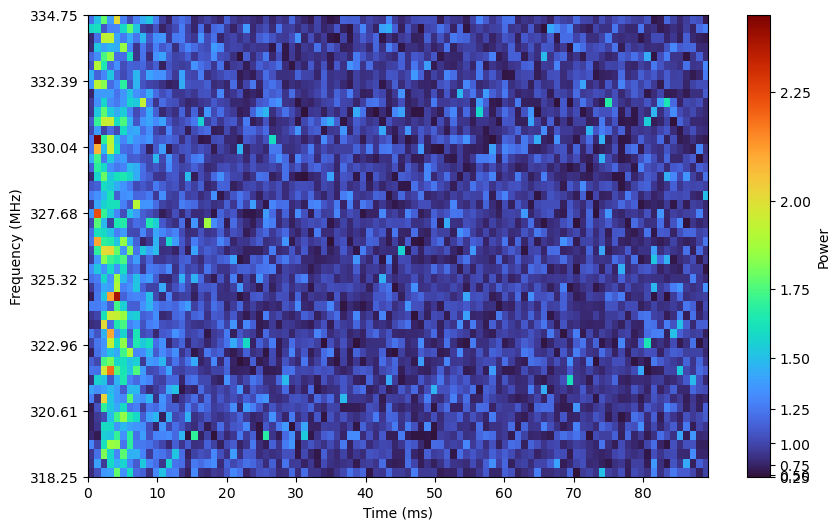

In [21]:

plot_intensity_matrix_single(folded, block_size,avg_blocks,sample_rate,bandwidth_MHZ,center_freq_MHZ,gamma=2.5)

avrage_folded = folded[:,:] / np.mean(folded,axis=0)

plot_intensity_matrix_single(avrage_folded, block_size,avg_blocks,sample_rate,bandwidth_MHZ,center_freq_MHZ,gamma=2.5)



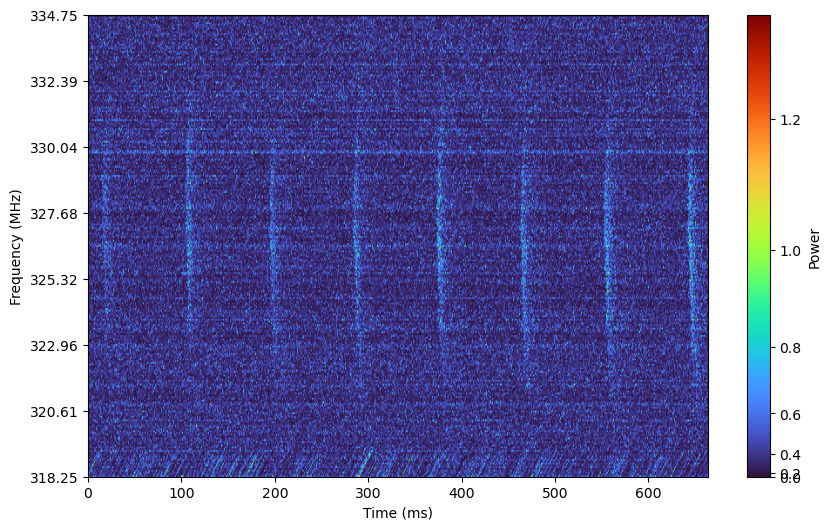

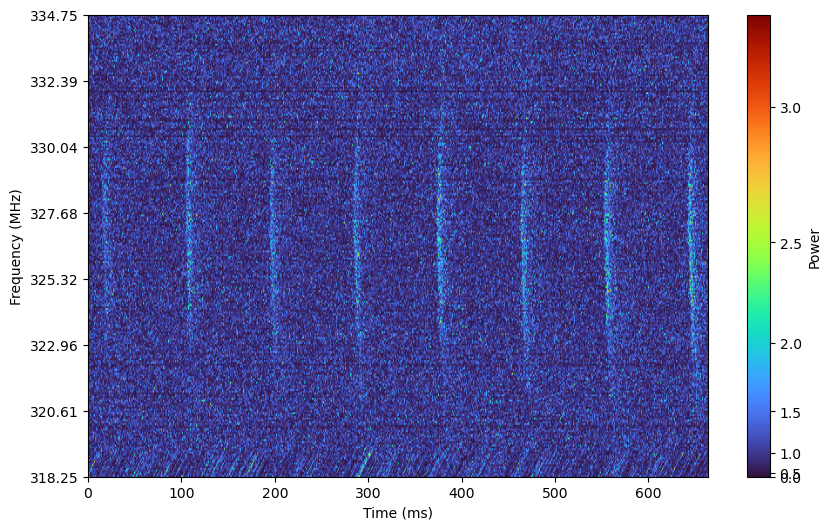

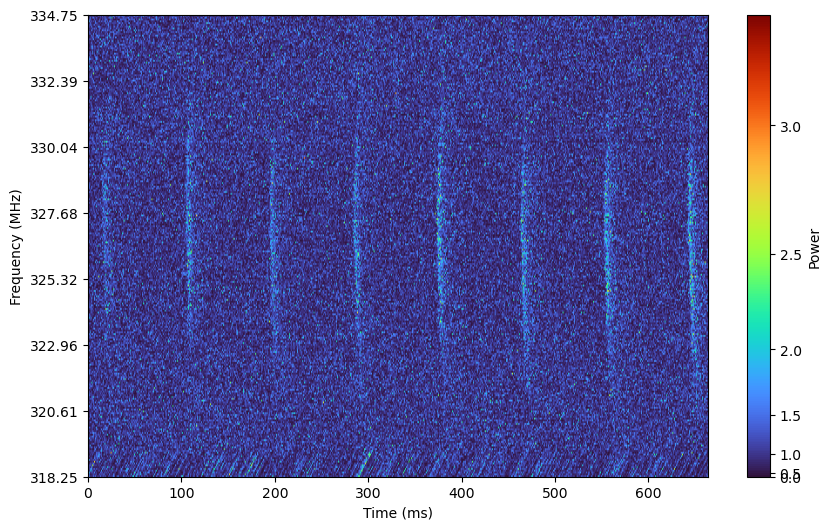

In [22]:


channel = 1
matrix = vela.dedispersed_choped_ch_s[channel]

plot_intensity_matrix_single(matrix, block_size,avg_blocks,sample_rate,bandwidth_MHZ,center_freq_MHZ,gamma=2.5)

plot_intensity_matrix_single(Anti_line_Noise(matrix), block_size,avg_blocks,sample_rate,bandwidth_MHZ,center_freq_MHZ,gamma=2.5)
plot_intensity_matrix_single(Anti_line_Normalise(matrix), block_size,avg_blocks,sample_rate,bandwidth_MHZ,center_freq_MHZ,gamma=2.5)




In [23]:
matrix = Anti_line_Noise(vela.dedispersed_choped_ch_s[1])
t_bin_s = (vela.block_size * vela.avg_blocks) / vela.sample_rate

folded = fold_time_series_from_matrix(matrix, pulse_period_s, t_bin_s)